## Work Description

We recall that in our previous notebook AutoMPG_EDA, we introduced the dataset AutoMPG, described its content and analysed the different relationships between our target variable 'MPG' and the other discret and continuous variables present in the dataset. Then, we proceed to construct, assess, and refine various regression models using the scikit-learn package in our notebook, "AutoMPG_Comparing_ML_Models". The current notebook is dedicated to another type of solution to solve Auto MPG prediction problem. In the era of deep learning, we explore the potential of neural networks for regression tasks. Utilizing the Keras Sequential API, our "AutoMPG_Keras_DNN_Model" notebook details the creation, evaluation, and enhancement of a basic deep learning regression model tailored to our dataset. We will address issues such as overfitting and employ various techniques to improve model performance, including cross-validation, early stopping, and hyperparameter tuning using Keras Tuner. Ultimately, we will compare the performance of our best-performing DNN model with the best-performing machine learning model identified in our previous experiments.

### Work Outline
1. Data preparation for the training
2. Creating the Keras DNN baseline model and evaluate it
3. Improving the model performances using the Early stopping technique
4. Hyperparameters Tuning using Keras Tuner
5. Evaluation and comparaison
6. Saving the final model

### Dataset description
**AUTOMPG**: *Mileage per gallon performances of various cars*

The data is technical spec of cars. The dataset is downloaded from UCI Machine Learning Repository.

**Source**
 Origin: This dataset was taken from the StatLib library which is maintained at Carnegie Mellon University. The dataset was used in the 1983 American Statistical Association Exposition.

**Attribute Information**

    * mpg: continuous
    * cylinders: multi-valued discrete
    * displacement: continuous
    * horsepower: continuous
    * weight: continuous
    * acceleration: continuous
    * model year: multi-valued discrete
    * origin: multi-valued discrete
    * car name: string (unique for each instance)


    

**Use these command to install Tensorflow and Keras Tuner if they are not already installed**

In [ ]:
!pip install tensorflow

In [ ]:
!pip install keras_tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.1 MB/s eta 0:00:00


**Importing the python libs and packages**

In [ ]:
from __future__ import absolute_import, print_function, division
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import pathlib
from tensorflow import keras
from keras import layers
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error, r2_score, mean_absolute_error, mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.utils import shuffle
import keras_tuner as kt
import random

print(tf.__version__)

#set random seeds
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)


2.15.0


# Task 1 : Data preparation for the training

### 1.1 Loading the data

In [ ]:
dataset_path= 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'

column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']


In [ ]:
dataset_raw= pd.read_csv(dataset_path, names=column_names, na_values='?', comment= "\t", sep=" ", skipinitialspace=True )

In [ ]:
dataset_raw.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1


In [ ]:
dataset_raw.shape

(398, 8)


### 1.2 Describing the data

In [ ]:
dataset_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   MPG           398 non-null    float64
 1   Cylinders     398 non-null    int64  
 2   Displacement  398 non-null    float64
 3   Horsepower    392 non-null    float64
 4   Weight        398 non-null    float64
 5   Acceleration  398 non-null    float64
 6   Model Year    398 non-null    int64  
 7   Origin        398 non-null    int64  
dtypes: float64(5), int64(3)
memory usage: 25.0 KB


In [ ]:
dataset_raw.describe()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
count,398.000000,398.000000,398.000000,392.000000,398.000000,398.000000,398.000000,398.000000
mean,23.514573,5.454774,193.425879,104.469388,2970.424623,15.568090,76.010050,1.572864
std,7.815984,1.701004,104.269838,38.491160,846.841774,2.757689,3.697627,0.802055
min,9.000000,3.000000,68.000000,46.000000,1613.000000,8.000000,70.000000,1.000000
25%,17.500000,4.000000,104.250000,75.000000,2223.750000,13.825000,73.000000,1.000000
50%,23.000000,4.000000,148.500000,93.500000,2803.500000,15.500000,76.000000,1.000000
75%,29.000000,8.000000,262.000000,126.000000,3608.000000,17.175000,79.000000,2.000000
max,46.600000,8.000000,455.000000,230.000000,5140.000000,24.800000,82.000000,3.000000


### 1.3 Cleaning the data

In [ ]:
dataset= dataset_raw.copy()

In [ ]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [ ]:
#Dropping the examples which don't have 'Horspower' values
dataset = dataset.dropna()

### 1.3 Encoding the '*origin*'

Encoding the 'Origin' and adding the columns which corresponds to the 3 distinct origins: USA, EUROPE and Japan

In [ ]:
origin = dataset.pop('Origin')

In [ ]:
dataset['USA'] = (origin==1) * 1
dataset['Europe']= (origin==2) * 1
dataset['Japan']= (origin==3) * 1
dataset.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,0,0
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,0,0
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,0,0
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,0,0
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,0,0


In [ ]:
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
393,27.0,4,140.0,86.0,2790.0,15.6,82,1,0,0
394,44.0,4,97.0,52.0,2130.0,24.6,82,0,1,0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1,0,0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1,0,0
397,31.0,4,119.0,82.0,2720.0,19.4,82,1,0,0


### 1.4 Splitting the data into Training and Testing sets



In [ ]:
print("Initial dataset shape : ",dataset.shape)
#The target value to be predicted
Y=dataset.pop('MPG')
#The predictors
X=dataset
#Shuffeling the data
X, Y = shuffle(X, Y, random_state=42)


Initial dataset shape :  (392, 10)


In [ ]:
#Shuffling the data
#Splitting the data into training and testing data
X_train, X_test, Y_train, Y_test= train_test_split(X, Y, test_size=0.2, random_state=42)
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(313, 9)
(313,)
(79, 9)
(79,)


### 1.5 Scaling the data


It is good practice to scale features that use different scales and ranges.One reason this is important is because the features are multiplied by the model weights. So, the scale of the outputs and the scale of the gradients are affected by the scale of the inputs. Although a model might converge without feature scaling, scaling makes training much more stable.

In [ ]:
X_train.describe().transpose()[['mean', 'std']]

,mean,std
Cylinders,5.472843,1.692763
Displacement,194.413738,104.242055
Horsepower,104.169329,38.818200
Weight,2983.785942,860.088320
Acceleration,15.607029,2.792564
Model Year,76.057508,3.641360
USA,0.626198,0.484587
Europe,0.169329,0.375643
Japan,0.204473,0.403962



**Scaling the data using Keras Normalization layer**

To integrate Scaling as part of the Keras model architecture, we can use the tf.keras.layers.experimental.preprocessing.Normalization layer. This approach allows us to include the scaling directly within the model, ensuring that any transformations are part of the model pipeline. Within Keras, there isn't a direct equivalent to StandardScaler from scikit-learn that explicitly states it performs Z-score normalization. However, the **Normalization layer** in Keras essentially performs the same function by normalizing the data to have 0 mean and a standard deviation of 1. In the following, we will create the  Normalization Layer for Standardization and test it :


The **tf.keras.layers.Normalization** is a clean and simple way to add feature normalization into your model.

In [ ]:
#A function to create the normalization layer
def create_normalizer(train_data) :
  normalizer = tf.keras.layers.Normalization(axis=-1)
  #Then, fit the state of the preprocessing layer to the data by calling Normalization.adapt:
  #At this step normalizer calculates the mean and variance, and store them in the layer
  normalizer.adapt(train_data)
  return normalizer

In [ ]:
# check the mean and variance stored  in the normalizer layer:
normalizer = create_normalizer(X_train)
print(normalizer.mean.numpy())

[[5.4728432e+00 1.9441376e+02 1.0416934e+02 2.9837859e+03 1.5607029e+01
  7.6057503e+01 6.2619805e-01 1.6932909e-01 2.0447285e-01]]


In [ ]:
#When the layer is called, it returns the input data, with each feature independently normalized:
first = np.array(X_train[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())


First example: [[   4.    90.    71.  2223.    16.5   75.     0.     1.     0. ]]

Normalized: [[-0.87 -1.   -0.86 -0.89  0.32 -0.29 -1.29  2.21 -0.51]]


# Task 3. Creating the Keras DNN Model

### 3.1 Building the Model

In [ ]:
#Fct to create a sequential Keras model having 3 dense layers
def build_Compile_Model(norm_layer, learning_rate=0.001) :
  model = tf.keras.Sequential ([
      norm_layer,
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dense(1) #The final Dense layer applies linear transformation per default
  ])

  #opt=tf.keras.optimizers.Adam(learning_rate=learning_rate)  # an alternative optimizer
  opt=tf.keras.optimizers.Adam(learning_rate=learning_rate)
  model.compile(loss='mse', optimizer=opt, metrics=['mse', 'mae'])
  return model

In [ ]:
#Build the model the normalization layer
model_base = build_Compile_Model (normalizer)
model_base.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizati  (None, 9)                 19        
 on)                                                             
                                                                 
 dense (Dense)               (None, 64)                640       
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4884 (19.08 KB)
Trainable params: 4865 (19.00 KB)
Non-trainable params: 19 (80.00 Byte)
_________________________________________________________________


### 3.2. Inspect the model

In [ ]:
#We will run the untrained mode to predict 10 examples to check that there is no errors
results= model_base.predict(X_train[:10])
results


1/1 [==============================] - 0s 169ms/step


array([[ 0.09626764],
       [-0.29456973],
       [-0.076373  ],
       [ 0.19647548],
       [ 0.30227754],
       [-0.17188522],
       [-0.00844163],
       [-0.14838812],
       [-0.32717025],
       [ 0.16076142]], dtype=float32)

### 3.3. Training the model

In [ ]:
#Special class to print 'dots' while training the model
class PrintDot(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, log) :
    if epoch %100 == 0 : print('')
    print('.', end='')


In [ ]:
#Training the model
%%time
history= model_base.fit(
    X_train,
    Y_train,
    validation_split=0.2,
    verbose=0, epochs=1000,
    callbacks=[PrintDot()]
)


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

### 3.5 Making Predictions

In [ ]:
#Computing the predictions
test_prediction = model_base.predict(X_test).flatten()

3/3 [==============================] - 0s 4ms/step


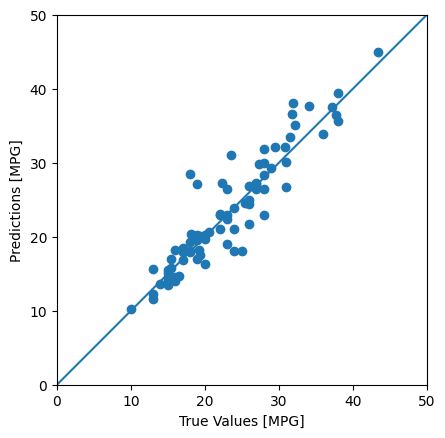

In [ ]:
#Plotting the predictions of the Testing set
a = plt.axes(aspect='equal')
plt.scatter(Y_test, test_prediction)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)


Now, check the error distribution:

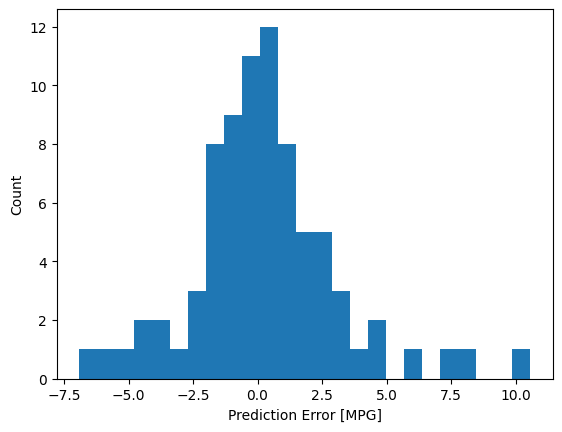

In [ ]:
error = test_prediction - Y_test
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [MPG]')
_ = plt.ylabel('Count')


### 3.4 Evaluating the model



In [ ]:
#Evaluate the baseline model
def evaluate_model (model, X_train, Y_train, X_test, Y_test) :
  #Get the base evaluations
  loss_train, mse_train, mae_train  = model.evaluate(X_train, Y_train)
  loss_test, mse_test, mae_test = model.evaluate(X_test, Y_test)

  #making predictions
  y_pred_test = model.predict(X_test).flatten()
  y_pred_train = model.predict(X_train).flatten()

  #Compute more metrics
  mape_train = mean_absolute_percentage_error(Y_train, y_pred_train )
  mape_test = mean_absolute_percentage_error(Y_test, y_pred_test )
  r2_test= r2_score(Y_test, y_pred_test)
  r2_train= r2_score(Y_train, y_pred_train)

  #Store the different evaluations
  model_evals= {
    'loss': loss_test,
    'mse': mse_test,
    'mae': mae_test,
    'mape_train':mape_train,
    'mape_test': mape_test,
    'r2-train': r2_train,
    'r2-test': r2_test
}

  return model_evals

In [ ]:
baseline_evaluations = evaluate_model(model_base,  X_train, Y_train, X_test, Y_test)
baseline_evaluations['model_name'] = 'dnn_baseline'
baseline_evaluations

10/10 [==============================] - 0s 2ms/step


{'loss': 8.293227195739746,
 'mse': 8.293227195739746,
 'mae': 2.0014002323150635,
 'mape_train': 0.047883195635895305,
 'mape_test': 0.08883173766425059,
 'r2-train': 0.9231445558695784,
 'r2-test': 0.8366553259386297,
 'model_name': 'dnn_baseline'}

**Signs of Overfitting**

  The baseline model shows signs of overfitting. It has a significantly lower training loss and MAE compared to its testing loss and MAE, and the R² score drops from 0.92 (training) to 0.85 (testing). The higher training performance and lower testing performance indicate the model fits the training data too well but doesn't generalize as effectively. Hence, we will try to inscpect the training by visualizing the model training progress  across the different epochs. Then, we will try a technique to handle the overfitting problem called the [Early stopping](https://en.wikipedia.org/wiki/Early_stopping) method and inspect its results, then we will try to fine-turne the hyperparameters of our model to find the best parameters sets that reduces the overfitting while mainting the high performances of the model.

# Task 4. Improving the model using Early stopping

### 4.1 Inspecting the training

Visualize the model training progress using the stats stored in history

In [ ]:
#Getting the training evals from the history object
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mse,mae,val_loss,val_mse,val_mae,epoch
995,1.906292,1.906292,0.855610,17.020782,17.020782,2.533658,995
996,1.897207,1.897207,0.846625,16.976082,16.976082,2.537139,996
997,1.870631,1.870631,0.835852,16.972471,16.972471,2.539300,997
998,1.963629,1.963629,0.865110,16.736843,16.736843,2.545821,998
999,1.973476,1.973476,0.879347,16.846485,16.846485,2.526801,999


In [ ]:
def plot_loss(history, metric='loss'):
  plt.figure()
  plt.plot(history.history[metric], label=metric)
  plt.plot(history.history['val_'+metric], label='val_'+metric)
  plt.ylim([0, 20])
  plt.xlabel('Epoch')
  plt.ylabel(metric + '[MPG]')
  plt.legend()
  plt.title("Model "+metric+" progress during the training")
  plt.grid(True)

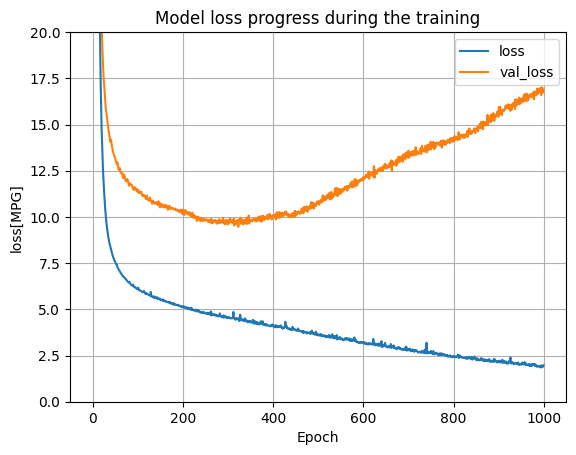

In [ ]:
#Plotting the different metrics progress during the training
plot_loss(history)

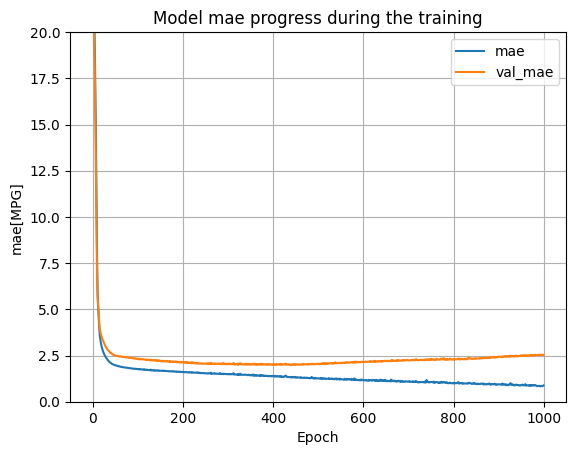

In [ ]:
plot_loss(history, 'mae')

The previous plots show the loss(mse) and the mae of our model for each epoch on the training and validation datasets. From reviewing this plot and evaluation results for each epochs, we can see that the model performance on the validation set and on the training set, sits flat and even gets worse towards the end of training. We can also notice that there is an opportunity to stop the learning earlier, perhaps somewhere around epoch 200.

Let's update the model.fit to automatically stop when the validation score doesn't improve. We will be using the **Early Stopping** Callback that test a Stopping condition for fixed amount of epochs. If a set of epochs elapses without any improvement, then we automatically stop the training.

### 4.2. Training the model with early Stopping parameter

In [ ]:
# Split the data into train and validation sets
X_train_v, X_val, Y_train_v, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=seed)

#Building the model
def build_model_early_stopping(normalizer, X_train, Y_train, X_val, Y_val, patience=10 ) :
  model_es = build_Compile_Model(normalizer)
  #The patience paramater is the amount of epoch to wait for, before checking the improvement
  early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_loss" , patience=patience)
  EPOCH= 1000
  #Training the model using new early stopping parameters
  history= model_es.fit(X_train, Y_train, epochs=EPOCH, validation_data=(X_val, Y_val), verbose=0, callbacks=[early_stop, PrintDot()])

  return model_es, history

In [ ]:
model_es_10, history_10= build_model_early_stopping(normalizer, X_train_v, Y_train_v, X_val, Y_val)



....................................................................................................
....................................................................................................
........................................................

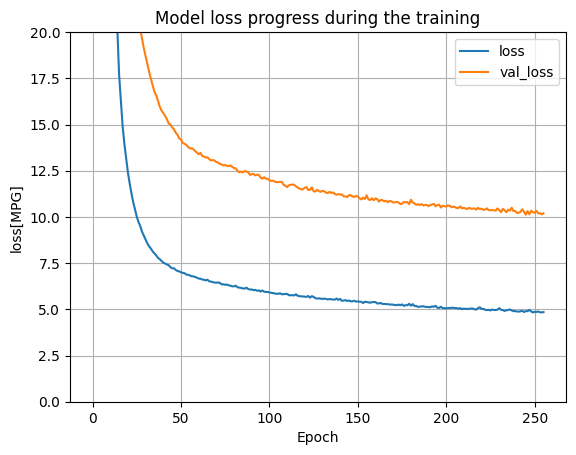

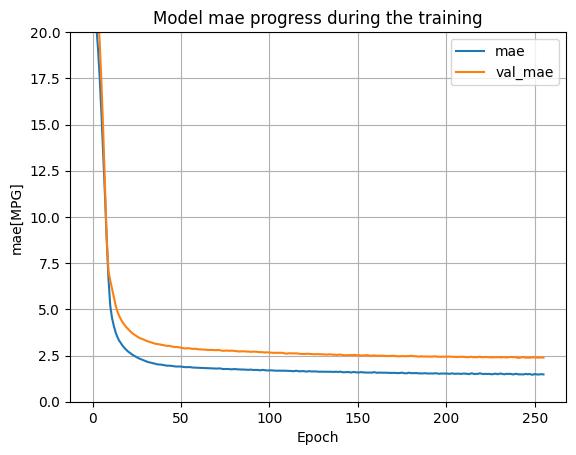

In [ ]:
plot_loss(history_10, 'loss')
plot_loss(history_10, 'mae')


In [ ]:
model_es_10_evals = evaluate_model(model_es_10, X_train, Y_train, X_test, Y_test)
model_es_10_evals['model_name'] = 'dnn_early_stop_10'
model_es_10_evals

10/10 [==============================] - 0s 2ms/step


{'loss': 6.234172821044922,
 'mse': 6.234172821044922,
 'mae': 1.8025315999984741,
 'mape_train': 0.06896341884285473,
 'mape_test': 0.08231690125889271,
 'r2-train': 0.9073099465631103,
 'r2-test': 0.8772108075217306,
 'model_name': 'dnn_early_stop_10'}

In [ ]:
all_results = pd.DataFrame([baseline_evaluations, model_es_10_evals])
all_results

,loss,mse,mae,mape_train,mape_test,r2-train,r2-test,model_name
0,8.293227,8.293227,2.001400,0.047883,0.088832,0.923145,0.836655,dnn_baseline
1,6.234173,6.234173,1.802532,0.068963,0.082317,0.907310,0.877211,dnn_early_stop_10


We can notice from the above plots that the training have stopped around 250 epochs. This is a huge optimization in the run time comparing to initial value of epochs (1000). From the comparision table, we can also notice an improvement in the performances of the model using the early stopping technique according to the different metrics computed on the testing data. The model dnn_early_stop_10 has also an improved generalization compared to the baseline. Both his training and testing losses are more balanced, and the R² score is higher on the testing set (0.877) than the baseline (0.836). This indicates that early stopping with a patience of 10 helped reduce overfitting and improve the overall performances. However, different patience values yield different performances, indicating the importance of tuning the patience parameter. In the next section, we will examine higher values of the 'patience' parameter and compare the new models.

### 4.3 Varying the 'patience' values and comparing the models

Now, we will experiment higher values of the 'patience' parameter for the early stopping and compare the performances of the different models. Some variability in metrics values across executions can be observed. This is normal due to the stochastic nature of neural network training, even when setting a random seed value. So, to overcome this variability, we will repeat each experiment with a  several times which correspond to the number of 'executions' passed as a parameter to the the above function. We will also split the data into K-folds to be able to conduct cross-validation.

The below function takes as input data X and Y, converted to numpy arrays to ensures compatibility with the KFold splitting. Then, the KFold function is used to split the data into training and validation sets. The indices generated by KFold are used to index the numpy arrays X and Y. For each fold and each execution, the model is built, compiled, and trained with early stopping. The model is evaluated on the validation set, and performance metrics are calculated and stored. Finally, the results from all folds and executions are averaged to provide a robust estimate of model performance.

In [ ]:
def evaluate_model_with_early_stopping_cv(normalizer, patience, X, Y, n_splits=3, epochs=1000, executions=3):
    #Splitting the train data into train and validation data in randomized way
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    results = []

    for train_index, val_index in kfold.split(X):
        print(len(train_index), len(val_index))
        X_train, X_val = X[train_index], X[val_index]
        Y_train, Y_val = Y[train_index], Y[val_index]

        for _ in range(executions):
            model_es = build_Compile_Model(normalizer)
            early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=patience, restore_best_weights=True)

            history = model_es.fit(X_train, Y_train, epochs=epochs, validation_data=(X_val, Y_val), verbose=2, callbacks=[early_stop])

            y_pred_val = model_es.predict(X_val)
            y_pred_train = model_es.predict(X_train)

            loss, mse, mae = model_es.evaluate(X_val, Y_val, verbose=0)
            mape_val = mean_absolute_percentage_error(Y_val, y_pred_val)
            mape_train = mean_absolute_percentage_error(Y_train, y_pred_train)
            r2_val = r2_score(Y_val, y_pred_val)
            r2_train = r2_score(Y_train, y_pred_train)

            results.append((loss, mse, mae, mape_train, mape_val, r2_train, r2_val))

            # Print the number of epochs run before early stopping
            epochs_run = len(history.history['loss'])
            print(f'Patience: {patience}, Execution: {_ + 1}, Fold: {kfold.get_n_splits()}, Epochs run: {epochs_run}')

    return np.mean(results, axis=0)

In [ ]:
X.shape, Y.shape

((392, 9), (392,))

In [ ]:
# Create and adapt the normalizer using the full dataset
normalizer = create_normalizer(X_train)

# Ensure your input data (X, Y) are numpy arrays
# If they are pandas DataFrames, convert them to numpy arrays
X_tr = X_train.values if isinstance(X_train, pd.DataFrame) else X_train
Y_tr = Y_train.values if isinstance(Y_train, pd.Series) else Y_train

# Call the cross-validation function
evals_10 = evaluate_model_with_early_stopping_cv(normalizer, 10, X_tr, Y_tr)
evals_30 = evaluate_model_with_early_stopping_cv(normalizer, 30, X_tr, Y_tr)
evals_50 = evaluate_model_with_early_stopping_cv(normalizer, 50, X_tr, Y_tr)

In [ ]:
results_df = pd.DataFrame({
    'model_name': ['dnn_10', 'dnn_30', 'dnn_50'],
    'loss': [evals_10[0], evals_30[0], evals_50[0]],
    'mse': [evals_10[1], evals_30[1], evals_50[1]],
    'mae': [evals_10[2], evals_30[2], evals_50[2]],
    'mape_train': [evals_10[3], evals_30[3], evals_50[3]],
    'mape_test': [evals_10[4], evals_30[4], evals_50[4]],
    'r2-train': [evals_10[5], evals_30[5], evals_50[5]],
    'r2-test': [evals_10[6], evals_30[6], evals_50[6]]
})

results_df

,model_name,loss,mse,mae,mape_train,mape_test,r2-train,r2-test
0,dnn_10,8.034317,8.034317,2.007684,0.074820,0.086074,0.902282,0.872267
1,dnn_30,7.693518,7.693518,1.992592,0.066826,0.086014,0.915932,0.877224
2,dnn_50,7.276938,7.276938,1.927630,0.063612,0.083346,0.923144,0.883832


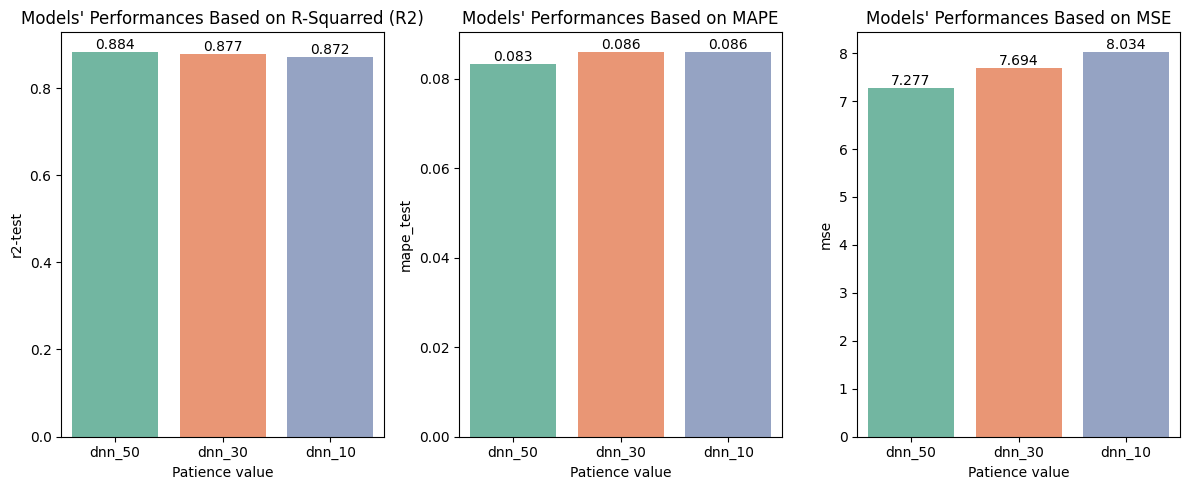

In [ ]:
fig, ax= plt.subplots(1,3, figsize=(12,5))

#Plotting the R-2 performances for each model and scaling method
#Sorting the data according R2 on testing data
results_df.sort_values(['r2-test'], ascending=False, inplace=True)
bar=sns.barplot(data=results_df, x='model_name', y='r2-test', palette='Set2', ax=ax[0] )
ax[0].set_xlabel("Patience value")
ax[0].set_title("Models' Performances Based on R-Squarred (R2)")
for container in bar.containers:
  values = container.datavalues
  labels = ["{:.3f}".format(val) for val in values]
  bar.bar_label(container, labels=labels)

results_df.sort_values(['mape_test'], ascending=True, inplace=True)
bar=sns.barplot(data=results_df, x='model_name', y='mape_test', palette='Set2', ax=ax[1] )
ax[1].set_xlabel("Patience value")
ax[1].set_title("Models' Performances Based on MAPE")
for container in bar.containers:
  values = container.datavalues
  labels = ["{:.3f}".format(val) for val in values]
  bar.bar_label(container, labels=labels)

results_df.sort_values(['mse'], ascending=True, inplace=True)
bar=sns.barplot(data=results_df, x='model_name', y='mse', palette='Set2', ax=ax[2] )
ax[2].set_xlabel("Patience value")
ax[2].set_title("Models' Performances Based on MSE")
for container in bar.containers:
  values = container.datavalues
  labels = ["{:.3f}".format(val) for val in values]
  bar.bar_label(container, labels=labels)

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

#### Comparison of Different Patience Values:

From the previous table and plot, we can draw some conclusions :
* **Improvement with Increased Patience**: As the patience value increases from 10 to 50, there is a consistent improvement in the model's performance metrics The loss, MSE, and MAE values decrease with higher patience values, indicating better model performance.
* **MAPE and R² Scores**:
  - The Mean Absolute Percentage Error (MAPE) for both train and test sets shows a slight decrease with increasing patience, suggesting more accurate predictions.
  - The R² score, which indicates the proportion of the variance in the dependent variable that is predictable from the independent variables, improves for both the train and test sets with higher patience. This signifies better model fit.
* **Optimal Patience Value**:
   - The model with a patience of 50 demonstrates the best performance across all metrics. It has the lowest loss (7.277), MSE (7.277), and MAE (1.928), along with the highest R² scores (0.9231 for train and 0.8838 for test) and lowest MAPE (0.0636 for train and 0.0833 for test).
   - Therefore, a patience value of 50 seems to be the most effective in this scenario, providing the best balance between training accuracy and generalization to the test data.


Based on these results, we will be using a patience value of 50 for early stopping to conduct our future experiments and applications. In the next section, we will investigate further improvement of our model performances by tuning other hyperparameters of our model such as the learning rate using Keras Tuner and cross-validation.

# Task 5 : hyperparameters finetuning of DNN model

- Conduct Hyperparameters tuning of our DNN models using [Keras Tuner](https://keras.io/keras_tuner/) and train the best model
- Compare the best DNN model to our baseline and inspect overfitting
- Compare the actual best DNN model to the best ML model that we have selected  following our previous experimentations.

KerasTuner is an easy-to-use, scalable hyperparameter optimization framework that solves the pain points of hyperparameter search. KerasTuner comes with Bayesian Optimization, Hyperband, and Random Search algorithms built-in.

### 5.1 Searching for best hyperparamters values using Keras Tuner

In [ ]:
#Function accepting the Tuner parameter space
def build_compile_hp_model(normalizer, hp):

  model = tf.keras.Sequential()

  #add the normalization layer
  model.add(normalizer)

  # Define hyperparameter search space for the model layers
  for i in range(hp.Int('num_layers', 1, 3)):
    # Tune the number of units in the first Dense layer
    model.add(tf.keras.layers.Dense(units=hp.Int(f'units_{i}', min_value=32, max_value=256, step=32),activation='relu'))


  #Add the final layer for linear transformation
  model.add(tf.keras.layers.Dense(1, activation='linear'))

  # Tune the learning rate for the optimizer
  opt=tf.keras.optimizers.Adam(hp.Choice('learning_rate', [1e-1, 1e-2, 0.05, 1e-3]))

  #compile the model
  model.compile(optimizer=opt,loss='mse', metrics=['mse', 'mae'])
  return model

In [ ]:
def tuning_model_early_stop_cv(X, Y, patience, epochs=1000, n_splits=5, max_trials=20, exec_per_trial=3) :
 # Ensure your input data (X, Y) are numpy arrays
 # If they are pandas DataFrames, convert them to numpy arrays
 X_tr = X.values if isinstance(X, pd.DataFrame) else X
 Y_tr = Y.values if isinstance(Y, pd.Series) else Y

 #Splitting the train data into train and validation data in randomized way
 kfold = KFold(n_splits=n_splits, shuffle=True, random_state=42)
 all_results = []
 all_epochs = []

 for train_index, val_index in kfold.split(X_tr):
      X_train, X_val = X_tr[train_index], X_tr[val_index]
      Y_train, Y_val = Y_tr[train_index], Y_tr[val_index]

      # Create and adapt the normalizer for the current fold
      normalizer = create_normalizer(X_train)

      def build_model_with_normalizer(hp):
          return build_compile_hp_model(normalizer, hp)

      # Initializing Keras Tuner
      tuner = kt.BayesianOptimization(
            build_model_with_normalizer,
            objective='val_loss',
            max_trials=max_trials, # Max number of trials (combinaison)
            executions_per_trial=exec_per_trial,
            project_name='dnn_tuning_param_'
      )

      # Define the callback EarlyStopping
      early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)

      #start searching for the best parameters
      tuner.search(X_train, Y_train, epochs=300, validation_data=(X_val, Y_val), callbacks=[early_stop])

      #Get the best parameters for this fold
      best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
      model = tuner.hypermodel.build(best_hps)
      history = model.fit(X_train, Y_train, epochs=epochs, validation_data=(X_val, Y_val), callbacks=[early_stop], verbose=0)

      # Extract the number of epochs for the best trial
      best_trial = tuner.oracle.get_best_trials(num_trials=1)[0]

      y_pred_val = model.predict(X_val)
      y_pred_train = model.predict(X_train)

      loss, mse, mae = model.evaluate(X_val, Y_val, verbose=0)
      mape_val = mean_absolute_percentage_error(Y_val, y_pred_val)
      mape_train = mean_absolute_percentage_error(Y_train, y_pred_train)
      r2_val = r2_score(Y_val, y_pred_val)
      r2_train = r2_score(Y_train, y_pred_train)

      # Print the number of epochs run before early stopping
      epochs_run = len(history.history['loss'])
      all_epochs.append(epochs_run)
      print(f'Fold: {kfold.get_n_splits()}, Epochs run: {epochs_run}')

      all_results.append((loss, mse, mae, mape_train, mape_val, r2_train, r2_val))

 avg_results = np.mean(all_results, axis=0)
 avg_epochs = int(np.mean(all_epochs))
 return avg_results, best_hps, avg_epochs

In [ ]:
epochs=600
patience=50
avg_results, best_hps, avg_epochs=tuning_model_early_stop_cv(X_train, Y_train, patience, epochs)

Trial 20 Complete [00h 00m 27s]
val_loss: 8.767060279846191

Best val_loss So Far: 8.767060279846191
Total elapsed time: 00h 17m 48s
8/8 [==============================] - 0s 2ms/step
Fold: 5, Epochs run: 97
Reloading Tuner from ./dnn_tuning_param_/tuner0.json
8/8 [==============================] - 0s 2ms/step
Fold: 5, Epochs run: 89
Reloading Tuner from ./dnn_tuning_param_/tuner0.json
8/8 [==============================] - 0s 2ms/step
Fold: 5, Epochs run: 67
Reloading Tuner from ./dnn_tuning_param_/tuner0.json
8/8 [==============================] - 0s 2ms/step
Fold: 5, Epochs run: 90
Reloading Tuner from ./dnn_tuning_param_/tuner0.json
8/8 [==============================] - 0s 2ms/step
Fold: 5, Epochs run: 110


In [ ]:
print(f"Best learning rate : {best_hps.get('learning_rate')}")
print(f"Best number of layers : {best_hps.get('num_layers')}")
for i in range(best_hps.get('num_layers')):
  # Tune the number of units in the first Dense layer
  print(f"Best units for the layer number {i} : {best_hps.get(f'units_{i}')}")

print("Cross-validation results: ", avg_results)
print("Average number of epochs: ", avg_epochs)

Best learning rate : 0.01
Best number of layers : 3
Best units for the layer number 0 : 96
Best units for the layer number 1 : 256
Best units for the layer number 2 : 96
Cross-validated results:  [6.73415642 6.73415642 1.84932592 0.06267546 0.08047494 0.92738983
 0.88846912]
Average number of epochs:  105


### 5.2 Building the model with the best parameters and evaluate it on the testing data

In [ ]:
#initial splitting of data, test data haven't been used in the cross-validation.
X_train.shape, X_test.shape

((313, 9), (79, 9))

In [ ]:
#Create the DNN model with best selected parameters
#We need a validation set to be used for the early stopping.
X_train_v, X_val, Y_train_v, Y_val= train_test_split(X_train, Y_train, shuffle=True, test_size=0.2, random_state=42)

normalizer= create_normalizer(X_train_v)
final_hp_model = build_compile_hp_model(normalizer, best_hps)
final_hp_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_4 (Normaliza  (None, 9)                 19        
 tion)                                                           
                                                                 
 dense_24 (Dense)            (None, 96)                960       
                                                                 
 dense_25 (Dense)            (None, 256)               24832     
                                                                 
 dense_26 (Dense)            (None, 96)                24672     
                                                                 
 dense_27 (Dense)            (None, 1)                 97        
                                                                 
Total params: 50580 (197.58 KB)
Trainable params: 50561 (197.50 KB)
Non-trainable params: 19 (80.00 Byte)
______________

In [ ]:
# Define the callback EarlyStopping
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
#Fit the model to the training data
history = final_hp_model.fit(X_train_v, Y_train_v, epochs=epochs, validation_data=(X_val, Y_val), callbacks=[early_stop], verbose=0)

In [ ]:
#Evaluate the final model on the testing data
model_hp = evaluate_model(final_hp_model, X_train_v, Y_train_v, X_test, Y_test)
model_hp['model_name'] = 'dnn_hp'
model_hp

8/8 [==============================] - 0s 2ms/step


{'loss': 6.965263366699219,
 'mse': 6.965263366699219,
 'mae': 2.005495548248291,
 'mape_train': 0.06428714354650743,
 'mape_test': 0.08952581065526793,
 'r2-train': 0.9324078846674972,
 'r2-test': 0.8628111159319911,
 'model_name': 'dnn_hp'}

### 5.3 Building DNN model with the best patience parameter and evaluate it on the test data

In [ ]:
model_es, history= build_model_early_stopping(normalizer, X_train_v, Y_train_v, X_val, Y_val, patience)
model_es = evaluate_model(model_es, X_train_v, Y_train_v, X_test, Y_test)
model_es['model_name'] = 'dnn_early_stop'
model_es




....................................................................................................
....................................................................................................
8/8 [==============================] - 0s 2ms/step


{'loss': 6.729881763458252,
 'mse': 6.729881763458252,
 'mae': 1.838894248008728,
 'mape_train': 0.06010559818323643,
 'mape_test': 0.08253618645196235,
 'r2-train': 0.9287887602341013,
 'r2-test': 0.8674472165329055,
 'model_name': 'dnn_early_stop'}

### 5.4 Building Gradient Boost model with its best parameters and evaluate it on the test data

In [ ]:
best_gb_params= {'learning_rate': 0.05,
 'max_depth': 3,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 300,
 'subsample': 0.5}
#Fit the model
best_gb_model = GradientBoostingRegressor(**best_gb_params, random_state=42)

pipeline = Pipeline( steps=[
   ('scaler', StandardScaler()),
    ('model' , best_gb_model)
]
)
pipeline.fit(X_train_v, Y_train_v)

#Get predictions
y_pred_test = pipeline.predict(X_test)
y_pred_train = pipeline.predict(X_train_v)

#Compute the evaluation metrics
train_mape = mean_absolute_percentage_error(Y_train_v, y_pred_train)
test_mape = mean_absolute_percentage_error(Y_test, y_pred_test)
test_r2= r2_score(Y_test, y_pred_test)
train_r2= r2_score(Y_train_v, y_pred_train)
mae= mean_absolute_error(Y_test, y_pred_test)
mse= mean_squared_error(Y_test, y_pred_test)

model_gb= {
    'model_name': 'gradient_boost',
    'loss': mse,
    'mse': mse,
    'mae': mae,
    'mape_train':train_mape,
    'mape_test': test_mape,
    'r2-train': train_r2,
    'r2-test': test_r2
}
model_gb

{'model_name': 'gradient_boost',
 'loss': 6.376240936330989,
 'mse': 6.376240936330989,
 'mae': 1.6886738237842958,
 'mape_train': 0.036347241664538885,
 'mape_test': 0.07661087335088482,
 'r2-train': 0.9848507017126681,
 'r2-test': 0.8744125720999134}

# Task 6. Comparing the different models

In [ ]:
#Create a dataframe by gathering the results of different experimentations
full_results = pd.DataFrame.from_records([model_hp, model_es, model_gb])
full_results

,loss,mse,mae,mape_train,mape_test,r2-train,r2-test,model_name
0,6.965263,6.965263,2.005496,0.064287,0.089526,0.932408,0.862811,dnn_hp
1,6.729882,6.729882,1.838894,0.060106,0.082536,0.928789,0.867447,dnn_early_stop
2,6.376241,6.376241,1.688674,0.036347,0.076611,0.984851,0.874413,gradient_boost


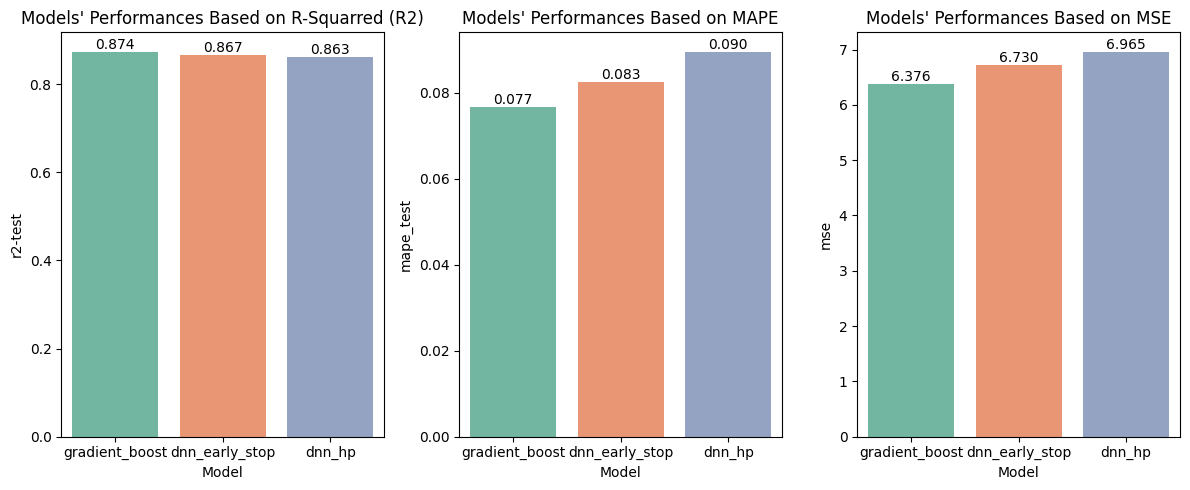

In [ ]:
#Plotting the R-2 performances for each model and scaling method
#Sorting the data according R2 on testing data
fig, ax= plt.subplots(1,3, figsize=(12,5))
full_results.sort_values(['r2-test'], ascending=False, inplace=True)
bar=sns.barplot(data=full_results, x='model_name', y='r2-test', palette='Set2', ax=ax[0] )
ax[0].set_xlabel("Model")
ax[0].set_title("Models' Performances Based on R-Squarred (R2)")
for container in bar.containers:
  values = container.datavalues
  labels = ["{:.3f}".format(val) for val in values]
  bar.bar_label(container, labels=labels)

full_results.sort_values(['mape_test'], ascending=True, inplace=True)
bar=sns.barplot(data=full_results, x='model_name', y='mape_test', palette='Set2', ax=ax[1] )
ax[1].set_xlabel("Model")
ax[1].set_title("Models' Performances Based on MAPE")
for container in bar.containers:
  values = container.datavalues
  labels = ["{:.3f}".format(val) for val in values]
  bar.bar_label(container, labels=labels)

full_results.sort_values(['mse'], ascending=True, inplace=True)
bar=sns.barplot(data=full_results, x='model_name', y='mse', palette='Set2', ax=ax[2] )
ax[2].set_xlabel("Model")
ax[2].set_title("Models' Performances Based on MSE")
for container in bar.containers:
  values = container.datavalues
  labels = ["{:.3f}".format(val) for val in values]
  bar.bar_label(container, labels=labels)

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

### Interpretation and Main Conclusions:

1. **Performance Across Models**:
   - **Gradient Boosting** demonstrates the best overall performance on the testing data, with the lowest **loss** (6.376), **MSE** (6.376), and **MAE** (1.689). It also achieves the highest **R² (Test)** of 0.8744 and the lowest **MAPE (Test)** of 0.0766.
   - **DNN with Early Stopping** has slightly better performance than the **DNN with Best Hyperparameters**. It has lower **loss**, **MSE**, and **MAE**, as well as better **R² (Test)** and **MAPE (Test)**.
   - **DNN with Best Hyperparameters** shows good performance but is outperformed by both the other models in all metrics.

2. **Overfitting and Model Complexity**:
   - **Gradient Boosting** shows very high **R² (Train)** of 0.9849, indicating it fits the training data exceptionally well. However, it still generalizes well to the testing data with an **R² (Test)** of 0.8744, suggesting minimal overfitting.
   - The **DNN with Early Stopping** shows balanced performance, with no significant overfitting as indicated by similar **R²** values for training (0.9288) and testing (0.8674).
   - The **DNN with Best Hyperparameters** also shows balanced performance but with slightly higher overfitting, indicated by the **R² (Train)** of 0.9324 and **R² (Test)** of 0.8628.

3. **Impact of Early Stopping and Hyperparameters on DNN**:
   - Early stopping helps prevent overfitting, leading to better generalization. The **DNN with Early Stopping** demonstrates this by achieving better performance metrics compared to the **DNN with Best Hyperparameters**.
   - The patience value of 50 for early stopping proves to be effective in enhancing the performance of the DNN model.
   - The **DNN with Best Hyperparameters** has a more complex architecture with more parameters (50,580) compared to the **DNN with Early Stopping** (4,884). Despite this, it does not outperform the simpler DNN model, suggesting that more complex architectures do not always yield better results.

### Recommendations:

- **Gradient Boosting** is preferred for this particular regression task, given its superior performance metrics.
- **DNN with Early Stopping** is a good alternative if neural networks are preferred, as it shows balanced performance with a simpler architecture.
- Further tuning and experiments could be conducted to explore if combining both methods (ensemble models) could yield even better results.


# Task 6. Saving the best DNN model

Call tf.keras.Model.save to save a model's architecture, weights, and training configuration in a single model.keras zip archive.

An entire model can be saved in three different file formats (the new .keras format and two legacy formats: SavedModel, and HDF5). Saving a model as path/to/model.keras automatically saves in the latest format.
Note: For Keras objects it's recommended to use the new high-level .keras format for richer, name-based saving and reloading, which is easier to debug. The low-level SavedModel format and legacy H5 format continue to be supported for existing code.

You can switch to the SavedModel format by:

    Passing save_format='tf' to save()
    Passing a filename without an extension

You can switch to the H5 format by:

    Passing save_format='h5' to save()
    Passing a filename that ends in .h5

Saving a fully-functional model is very useful—you can load them in TensorFlow.js (Saved Model, HDF5) and then train and run them in web browsers, or convert them to run on mobile devices using TensorFlow Lite (Saved Model, HDF5)

* Custom objects (for example, subclassed models or layers) require special attention when saving and loading. Refer to the Saving custom objects section below.
see https://www.tensorflow.org/tutorials/keras/save_and_load

In [ ]:
final_model = final_hp_model

In [ ]:
!mkdir -p saved_model

In [ ]:
final_model.save('save_model/dnn_model_MPG_reg-3', save_format="tf") #saving in the newer format of keras => 'model.save('dnn_model_MPG_reg.keras')'


In [ ]:

!ls save_model/dnn_model_MPG_reg-3


assets	fingerprint.pb	keras_metadata.pb  saved_model.pb  variables


Loading the model

In [ ]:
# Recreate the exact same model, including its weights and the optimizer
new_model = tf.keras.models.load_model('save_model/dnn_model_MPG_reg-3')


In [ ]:
new_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_4 (Normaliza  (None, 9)                 19        
 tion)                                                           
                                                                 
 dense_24 (Dense)            (None, 96)                960       
                                                                 
 dense_25 (Dense)            (None, 256)               24832     
                                                                 
 dense_26 (Dense)            (None, 96)                24672     
                                                                 
 dense_27 (Dense)            (None, 1)                 97        
                                                                 
Total params: 50580 (197.58 KB)
Trainable params: 50561 (197.50 KB)
Non-trainable params: 19 (80.00 Byte)
______________

In [ ]:
# Evaluate the restored model
loss, mse, mae = new_model.evaluate(X_test, Y_test, verbose=2)
y_pred_test = new_model.predict(X_test).flatten()
r2_test = r2_score(Y_test, y_pred_test)
mape_test = mean_absolute_percentage_error(Y_test, y_pred_test)

print(f"Testing set Mean Absolute Error {mae:.3f} MPG")
print(f"Testing set Mean Squarred Error {mse:.3f} MPG")
print(f"Testing set Mean Absolute Percentage Error {mape_test:.3f} MPG")
print(f"Testing R-squarred {r2_test:.3f} MPG")



3/3 - 0s - loss: 6.9653 - mse: 6.9653 - mae: 2.0055 - 207ms/epoch - 69ms/step
3/3 [==============================] - 0s 4ms/step
Testing set Mean Absolute Error 2.005 MPG
Testing set Mean Squarred Error 6.965 MPG
Testing set Mean Absolute Percentage Error 0.090 MPG
Testing R-squarred 0.863 MPG


The model didn't lose its performances after the saving in the TF format.

I have tested the keras and the h5 format but I got errors. In fact, when loading the saved model, the shape of the input data was lost. This is due to the Normalization layer. A bug report exists in this link https://github.com/keras-team/keras/issues/15348